<a href="https://colab.research.google.com/github/jasonnho/flygaruda-sentiment-analysis/blob/main/notebook/flygaruda_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, re, ast, math
from collections import Counter, defaultdict
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('regex_garuda_reviews.csv')

In [ ]:
df.head(5)

,content,content_stemmed_no_common_2,content_regex,content_regex_norm,tokens_nltk,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,harus belajar lagi bagaimana cara kau menghada...,ajar kau hadap kritik btw makannmu enak sorry ...,ajar kau hadap kritik btw makannmu enak sorry ...,ajar kau hadap kritik btw makannmu enak sorry ...,"['ajar', 'kau', 'hadap', 'kritik', 'btw', 'mak...",4,0,6.16.0,2025-09-06 00:58:19,NaN,NaN
1,"maskapai maling, menipu customer dengan inform...",maskapai maling tipu customer informasi palsu ...,maskapai maling tipu customer informasi palsu ...,maskapai maling tipu customer informasi palsu ...,"['maskapai', 'maling', 'tipu', 'customer', 'in...",1,1,NaN,2025-09-03 09:23:02,NaN,NaN
2,dulu dpt platinum bs 5-6 tahun g pernah turun....,platinum 56 turun bijak megap2 tahan bronzesil...,platinum turun bijak megap tahan bronzesilver ...,platinum turun bijak megap tahan bronzesilver ...,"['platinum', 'turun', 'bijak', 'megap', 'tahan...",2,2,6.17.0,2025-08-25 16:38:50,NaN,NaN
3,sy delay 20 jam dgn penerbangan conecting seha...,delay 20 jam terbang conecting sore gatuda hai...,delay jam terbang conecting sore gatuda hai me...,delay jam terbang conecting sore gatuda hai me...,"['delay', 'jam', 'terbang', 'conecting', 'sore...",1,0,6.17.0,2025-08-21 12:06:28,NaN,NaN
4,sedikit panik setelah check-in boarding tiket ...,panik checkin boarding tiket cuman,panik checkin boarding tiket cuman,panik checkin boarding tiket cuman,"['panik', 'checkin', 'boarding', 'tiket', 'cum...",4,0,6.17.0,2025-08-18 05:44:32,NaN,NaN


In [ ]:
# STEP 2: Tentukan kolom teks utama dan lihat contoh

CANDIDATE_TEXT_COLS = [
    "content_regex_norm", "content_regex",
    "content_stemmed_no_common_2", "content_stemmed",
    "content", "review", "text", "body"
]

def pick_text_col(df, candidates):
    # pakai kolom yang ada di daftar kandidat
    for c in candidates:
        if c in df.columns:
            return c
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if not obj_cols:
        raise ValueError("Tidak menemukan kolom teks (tipe object). Pilih manual.")
    med_lens = {c: df[c].astype(str).str.len().median() for c in obj_cols}
    return max(med_lens, key=med_lens.get)

# 2) Set TEXT_COL
try:
    TEXT_COL
except NameError:
    TEXT_COL = pick_text_col(df, CANDIDATE_TEXT_COLS)

print("TEXT_COL =", TEXT_COL)

# 5 contoh awal
display(df[[TEXT_COL]].head(5))

# Lihat daftar kolom teks (object) lain untuk cross-check
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
print("Kolom bertipe object:", obj_cols[:30])  # batasi tampilan sampai 30 kolom


TEXT_COL = content_regex_norm


,content_regex_norm
0,ajar kau hadap kritik btw makannmu enak sorry ...
1,maskapai maling tipu customer informasi palsu ...
2,platinum turun bijak megap tahan bronzesilver ...
3,delay jam terbang conecting sore gatuda hai me...
4,panik checkin boarding tiket cuman


Kolom bertipe object: ['content', 'content_stemmed_no_common_2', 'content_regex', 'content_regex_norm', 'tokens_nltk', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt']


In [ ]:
# Cek kualitas dasar (missing values & duplikat) di kolom teks

n_docs = len(df)
missing = df[TEXT_COL].isna().sum()
dupes   = df[TEXT_COL].duplicated(keep=False).sum()

print(f"Jumlah dokumen total : {n_docs}")
print(f"Missing/NaN          : {missing} baris ({missing/n_docs:.2%})")
print(f"Duplikat persis      : {dupes} baris ({dupes/n_docs:.2%})")

# Tampilkan contoh baris yang kosong (kalau ada)
if missing > 0:
    display(df[df[TEXT_COL].isna()].head(5))


Jumlah dokumen total : 4851
Missing/NaN          : 120 baris (2.47%)
Duplikat persis      : 1905 baris (39.27%)


,content,content_stemmed_no_common_2,content_regex,content_regex_norm,tokens_nltk,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
67,baik,NaN,NaN,NaN,[],5,0,6.9.1,2025-02-13 06:12:26,NaN,NaN
125,❤️,NaN,NaN,NaN,[],5,0,6.8.2,2024-10-12 23:52:52,NaN,NaN
158,baik,NaN,NaN,NaN,[],5,0,6.6.0,2024-08-04 12:48:39,NaN,NaN
180,sudah lebih baik dari sebelumnya,NaN,NaN,NaN,[],5,0,6.1.4,2024-07-01 23:15:19,NaN,NaN
203,malah keluar sendiri,NaN,NaN,NaN,[],1,0,6.2.0,2024-05-27 09:32:29,NaN,NaN


Statistik panjang karakter:
count    4851.000000
mean       27.515976
std        36.717937
min         1.000000
25%         5.000000
50%        13.000000
75%        34.000000
max       333.000000
Name: _char_len, dtype: float64

Statistik panjang token:
count    4851.000000
mean        4.417440
std         5.514436
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        55.000000
Name: _token_len, dtype: float64


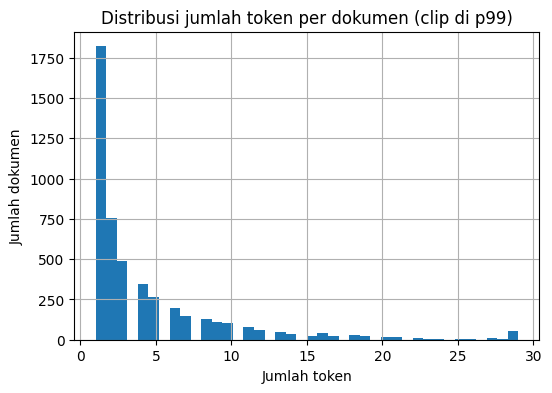

In [ ]:
#  Distribusi panjang teks (karakter & token)

df["_char_len"] = df[TEXT_COL].astype(str).str.len()

df["_token_len"] = df[TEXT_COL].astype(str).str.split().apply(len)

print("Statistik panjang karakter:")
print(df["_char_len"].describe())

print("\nStatistik panjang token:")
print(df["_token_len"].describe())

# plot distribusi jumlah token

plt.figure(figsize=(6,4))
df["_token_len"].clip(upper=df["_token_len"].quantile(0.99)).hist(bins=40)
plt.title("Distribusi jumlah token per dokumen (clip di p99)")
plt.xlabel("Jumlah token")
plt.ylabel("Jumlah dokumen")
plt.show()

In [ ]:
#Clean baris NaN di text_col

# Hapus baris NaN di kolom teks
df_clean = df.dropna(subset=[TEXT_COL]).copy()

# Hapus baris yang teksnya kosong string ("" atau " ")
df_clean = df_clean[df_clean[TEXT_COL].astype(str).str.strip() != ""]

print("Setelah cleaning (tanpa hapus duplikat):")
print(f"Jumlah dokumen: {len(df_clean)}")
print(f"Missing values : {df_clean[TEXT_COL].isna().sum()}")
print(f"Teks kosong    : {(df_clean[TEXT_COL].astype(str).str.strip() == '').sum()}")


Setelah cleaning (tanpa hapus duplikat):
Jumlah dokumen: 4731
Missing values : 0
Teks kosong    : 0


Ukuran kosakata : 3797
10 kata paling sering:
bagus           382
good            353
indonesia       321
bantu           319
mudah           295
miles           279
baik            261
login           236
mantap          228
update          215

Jumlah kata yang muncul sekali (hapax): 2461 (64.8% dari vocab)


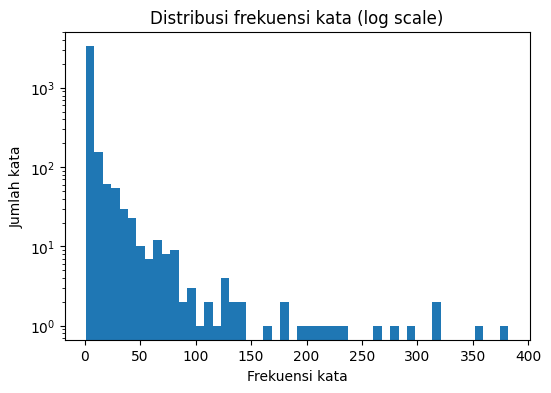

In [ ]:
# fungsi normalisasi + tokenisasi sederhana
TOKEN_RE = re.compile(r"[^0-9a-zA-Z\u00C0-\u024F\u1E00-\u1EFF'\s]+")  # hapus simbol selain huruf/angka

def normalize(text: str) -> str:
    text = text.lower()
    text = TOKEN_RE.sub(" ", text)   # ganti simbol non-alfanumerik jadi spasi
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    text = normalize(text)
    return text.split()

df_clean["_tokens"] = df_clean[TEXT_COL].astype(str).apply(tokenize)

# hitung frekuensi kata (term frequency)
token_counter = Counter(chain.from_iterable(df_clean["_tokens"]))

print("Ukuran kosakata :", len(token_counter))
print("10 kata paling sering:")
for tok, cnt in token_counter.most_common(10):
    print(f"{tok:15s} {cnt}")

# cek rare words
hapax = sum(1 for t,c in token_counter.items() if c == 1)
print(f"\nJumlah kata yang muncul sekali (hapax): {hapax} ({hapax/len(token_counter):.1%} dari vocab)")

# distribusi frekuensi kata
freqs_sorted = sorted(token_counter.values(), reverse=True)

plt.figure(figsize=(6,4))
plt.hist(freqs_sorted, bins=50, log=True)
plt.title("Distribusi frekuensi kata (log scale)")
plt.xlabel("Frekuensi kata")
plt.ylabel("Jumlah kata")
plt.show()

In [ ]:
# Eksplor cutoff rare words

# distribusi frekuensi
freqs = np.array(list(token_counter.values()))

total_token = freqs.sum()
vocab_size  = len(freqs)

print(f"Total token di korpus: {total_token}")
print(f"Vocab size: {vocab_size}")

# fungsi bantu: berapa banyak kata/token terhapus jika cutoff tertentu
def cutoff_stats(k):
    removed_vocab = np.sum(freqs < k)
    removed_token = np.sum(freqs[freqs < k])
    return {
        "cutoff": k,
        "removed_vocab": removed_vocab,
        "removed_vocab_pct": removed_vocab / vocab_size,
        "removed_token": removed_token,
        "removed_token_pct": removed_token / total_token
    }

# cek untuk cutoff 2,3,5
for k in [2,3,5]:
    stats = cutoff_stats(k)
    print(
        f"\nmin_count >= {k}: "
        f"hapus {stats['removed_vocab']} kata unik "
        f"({stats['removed_vocab_pct']:.1%} vocab), "
        f"hilang {stats['removed_token_pct']:.1%} token"
    )

# lihat cutoff coverage otomatis
freqs_sorted = np.sort(freqs)[::-1]
cum = np.cumsum(freqs_sorted) / total_token

for cov in [0.95, 0.97, 0.99]:
    idx = np.searchsorted(cum, cov)
    print(f"Coverage {int(cov*100)}% tercapai dengan {idx} kata paling sering")


Total token di korpus: 21309
Vocab size: 3797

min_count >= 2: hapus 2461 kata unik (64.8% vocab), hilang 11.5% token

min_count >= 3: hapus 2817 kata unik (74.2% vocab), hilang 14.9% token

min_count >= 5: hapus 3154 kata unik (83.1% vocab), hilang 20.2% token
Coverage 95% tercapai dengan 2731 kata paling sering
Coverage 97% tercapai dengan 3157 kata paling sering
Coverage 99% tercapai dengan 3583 kata paling sering


In [ ]:
# Rare Words Removal (pakai cutoff min_count=2)

MIN_COUNT = 2

rare_words = {t for t,c in token_counter.items() if c < MIN_COUNT}

print(f"Jumlah kata yang akan dihapus: {len(rare_words)} "
      f"({len(rare_words)/vocab_size:.1%} dari vocab)")

# filter token
def filter_tokens(tokens, to_remove):
    return [t for t in tokens if t not in to_remove]

df_clean["tokens_clean"] = df_clean["_tokens"].apply(lambda toks: filter_tokens(toks, rare_words))
df_clean["text_clean"]   = df_clean["tokens_clean"].apply(lambda toks: " ".join(toks))

# cek hasil
print("Contoh sebelum -> sesudah:")
for i in range(3):
    print("RAW :", df_clean["_tokens"].iloc[i])
    print("CLEAN:", df_clean["tokens_clean"].iloc[i])
    print("---")


Jumlah kata yang akan dihapus: 2461 (64.8% dari vocab)
Contoh sebelum -> sesudah:
RAW : ['ajar', 'kau', 'hadap', 'kritik', 'btw', 'makannmu', 'enak', 'sorry', 'sayang', 'no', 'tdk', 'pakai']
CLEAN: ['ajar', 'kau', 'kritik', 'enak', 'sorry', 'sayang', 'no', 'pakai']
---
RAW : ['maskapai', 'maling', 'tipu', 'customer', 'informasi', 'palsu', 'info', 'expired', 'depan', 'miles', 'tibatiba', 'potong', 'komplain', 'ber', 'bulanbulan', 'response', 'jual', 'panjang', 'laku', 'miles', 'scam', 'komplot', 'maling', 'jebak', 'customer', 'hatihati', 'busuk']
CLEAN: ['maskapai', 'maling', 'tipu', 'customer', 'informasi', 'info', 'expired', 'depan', 'miles', 'tibatiba', 'potong', 'komplain', 'ber', 'jual', 'panjang', 'laku', 'miles', 'maling', 'jebak', 'customer', 'busuk']
---
RAW : ['platinum', 'turun', 'bijak', 'megap', 'tahan', 'bronzesilver', 'kayak', 'pakai', 'poin', 'an', 'gf', 'deh', 'faedah', 'mamfat', 'guna', 'jg', 'kantor', 'sih', 'nyuruh', 'faedah', 'poin', 'gf', 'blue', 'wkwkwkw', 'anjir'

In [ ]:
# Hapus dokumen kosong setelah rare words removal

before = len(df_clean)

# Buang baris yang text_clean kosong ("") atau NaN
df_clean = df_clean.dropna(subset=["text_clean"])
df_clean = df_clean[df_clean["text_clean"].str.strip() != ""]

after = len(df_clean)

print(f"Jumlah dokumen sebelum drop : {before}")
print(f"Jumlah dokumen sesudah drop : {after}")
print(f"Jumlah baris kosong yang dihapus: {before - after}")


Jumlah dokumen sebelum drop : 4731
Jumlah dokumen sesudah drop : 4610
Jumlah baris kosong yang dihapus: 121


Ukuran kosakata baru: 1336
10 kata paling sering (setelah cleaning):
bagus           382
good            353
indonesia       321
bantu           319
mudah           295
miles           279
baik            261
login           236
mantap          228
update          215

Statistik panjang token (setelah cleaning):
count    4610.000000
mean        4.088503
std         4.851447
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        49.000000
Name: _token_len_clean, dtype: float64


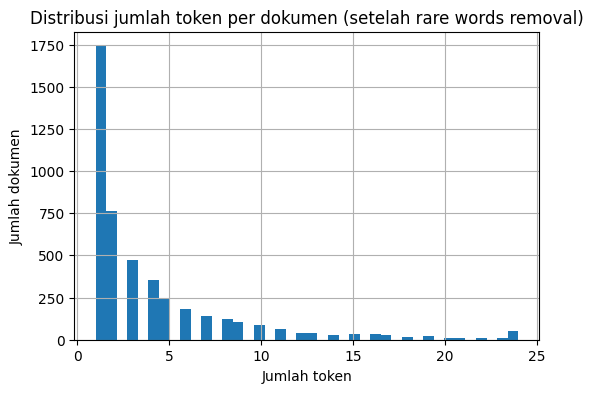

In [ ]:
# Explore lagi setelah removal

# hitung frekuensi kata baru
clean_counter = Counter(chain.from_iterable(df_clean["tokens_clean"]))
vocab_new = len(clean_counter)

print("Ukuran kosakata baru:", vocab_new)
print("10 kata paling sering (setelah cleaning):")
for tok, cnt in clean_counter.most_common(10):
    print(f"{tok:15s} {cnt}")

# panjang token per dokumen setelah cleaning
df_clean["_token_len_clean"] = df_clean["tokens_clean"].apply(len)

print("\nStatistik panjang token (setelah cleaning):")
print(df_clean["_token_len_clean"].describe())

# plot distribusi panjang token setelah cleaning
plt.figure(figsize=(6,4))
df_clean["_token_len_clean"].clip(upper=df_clean["_token_len_clean"].quantile(0.99)).hist(bins=40)
plt.title("Distribusi jumlah token per dokumen (setelah rare words removal)")
plt.xlabel("Jumlah token")
plt.ylabel("Jumlah dokumen")
plt.show()

/tmp/ipython-input-3984103492.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="viridis")


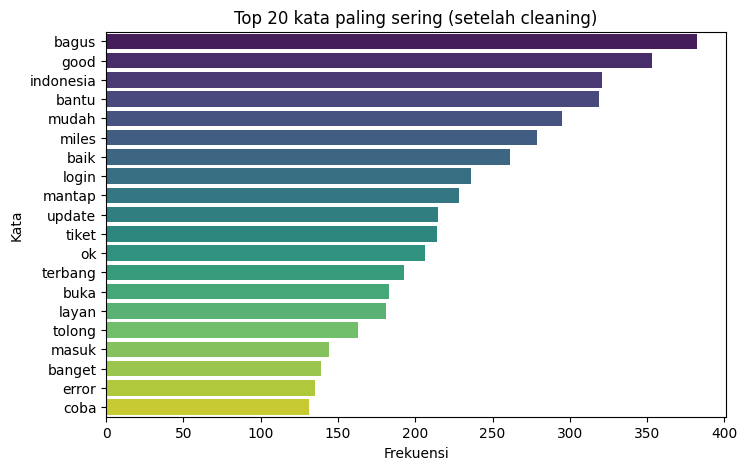

In [ ]:
# Barplot commonwords
import matplotlib.pyplot as plt
import seaborn as sns

top_words = pd.DataFrame(clean_counter.most_common(20), columns=["word","count"])

plt.figure(figsize=(8,5))
sns.barplot(y="word", x="count", data=top_words, palette="viridis")
plt.title("Top 20 commonwords (setelah cleaning)")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()


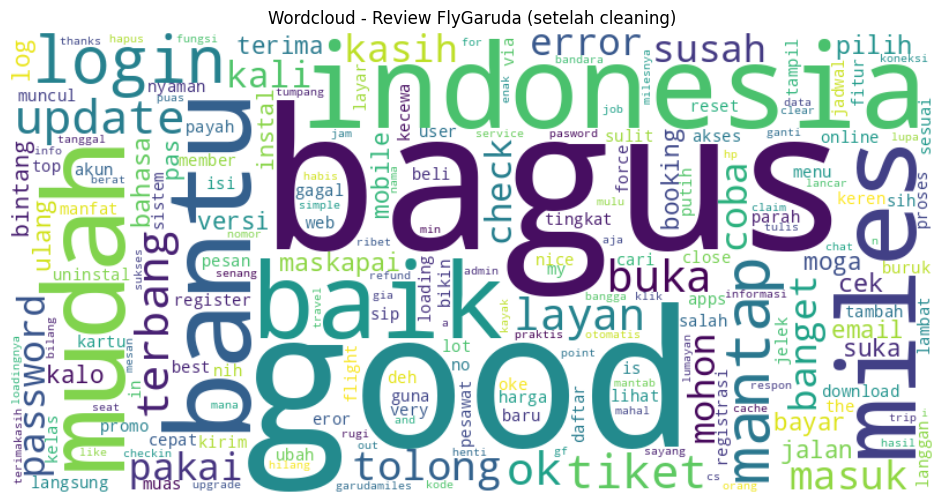

In [ ]:
#  Wordcloud
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis")\
     .generate_from_frequencies(clean_counter)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Review FlyGaruda (setelah cleaning)")
plt.show()


In [ ]:
# Bigram (2-kata) paling sering
from collections import Counter

def get_ngrams(tokens, n=2):
    return zip(*[tokens[i:] for i in range(n)])

bigram_counter = Counter()
for toks in df_clean["tokens_clean"]:
    bigram_counter.update(get_ngrams(toks, n=2))

top_bigrams = bigram_counter.most_common(20)
print("Top 20 bigram:")
for bg, cnt in top_bigrams:
    print(f"{' '.join(bg):20s} {cnt}")


Top 20 bigram:
tolong baik          75
terima kasih         74
bahasa indonesia     55
mohon baik           51
the best             42
beli tiket           38
pesan tiket          29
check in             29
layar putih          27
instal ulang         25
reset password       24
force close          22
log out              21
kasih bintang        20
good job             20
tiket pesawat        20
harga tiket          19
kirim email          19
is the               19
check online         18


In [ ]:
# Buat label sentimen dari rating bintang

RATING_COL = "score"   # nama kolom rating

def map_sentiment(star):
    try:
        star = int(star)
    except:
        return None
    if star in [4,5]:
        return "positive"
    elif star == 3:
        return "neutral"
    elif star in [1,2]:
        return "negative"
    return None

df_clean["sentiment"] = df_clean[RATING_COL].apply(map_sentiment)

# cek distribusi label
print("Distribusi label sentimen:")
print(df_clean["sentiment"].value_counts(normalize=True).round(3))


Distribusi label sentimen:
sentiment
positive    0.643
negative    0.272
neutral     0.085
Name: proportion, dtype: float64


In [ ]:
df_clean.head()

,content,content_stemmed_no_common_2,content_regex,content_regex_norm,tokens_nltk,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,_char_len,_token_len,_tokens,tokens_clean,text_clean,_token_len_clean,sentiment
0,harus belajar lagi bagaimana cara kau menghada...,ajar kau hadap kritik btw makannmu enak sorry ...,ajar kau hadap kritik btw makannmu enak sorry ...,ajar kau hadap kritik btw makannmu enak sorry ...,"['ajar', 'kau', 'hadap', 'kritik', 'btw', 'mak...",4,0,6.16.0,2025-09-06 00:58:19,NaN,NaN,65,12,"[ajar, kau, hadap, kritik, btw, makannmu, enak...","[ajar, kau, kritik, enak, sorry, sayang, no, p...",ajar kau kritik enak sorry sayang no pakai,8,positive
1,"maskapai maling, menipu customer dengan inform...",maskapai maling tipu customer informasi palsu ...,maskapai maling tipu customer informasi palsu ...,maskapai maling tipu customer informasi palsu ...,"['maskapai', 'maling', 'tipu', 'customer', 'in...",1,1,NaN,2025-09-03 09:23:02,NaN,NaN,193,27,"[maskapai, maling, tipu, customer, informasi, ...","[maskapai, maling, tipu, customer, informasi, ...",maskapai maling tipu customer informasi info e...,21,negative
2,dulu dpt platinum bs 5-6 tahun g pernah turun....,platinum 56 turun bijak megap2 tahan bronzesil...,platinum turun bijak megap tahan bronzesilver ...,platinum turun bijak megap tahan bronzesilver ...,"['platinum', 'turun', 'bijak', 'megap', 'tahan...",2,2,6.17.0,2025-08-25 16:38:50,NaN,NaN,168,28,"[platinum, turun, bijak, megap, tahan, bronzes...","[platinum, turun, bijak, tahan, kayak, pakai, ...",platinum turun bijak tahan kayak pakai poin an...,23,negative
3,sy delay 20 jam dgn penerbangan conecting seha...,delay 20 jam terbang conecting sore gatuda hai...,delay jam terbang conecting sore gatuda hai me...,delay jam terbang conecting sore gatuda hai me...,"['delay', 'jam', 'terbang', 'conecting', 'sore...",1,0,6.17.0,2025-08-21 12:06:28,NaN,NaN,160,23,"[delay, jam, terbang, conecting, sore, gatuda,...","[delay, jam, terbang, sore, hai, hotel, transp...",delay jam terbang sore hai hotel transportasi ...,17,negative
4,sedikit panik setelah check-in boarding tiket ...,panik checkin boarding tiket cuman,panik checkin boarding tiket cuman,panik checkin boarding tiket cuman,"['panik', 'checkin', 'boarding', 'tiket', 'cum...",4,0,6.17.0,2025-08-18 05:44:32,NaN,NaN,34,5,"[panik, checkin, boarding, tiket, cuman]","[checkin, boarding, tiket, cuman]",checkin boarding tiket cuman,4,positive


/tmp/ipython-input-1482787825.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent_counts.index, y=sent_counts.values, palette="Set2")


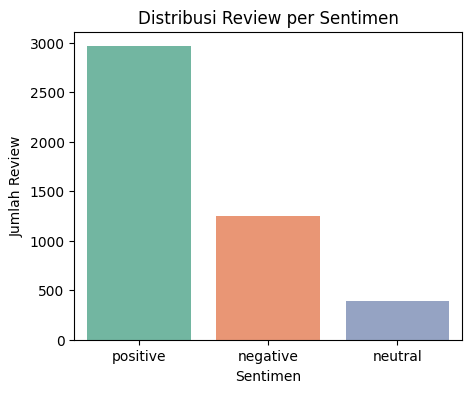

sentiment
positive    2964
negative    1252
neutral      394
Name: count, dtype: int64


In [ ]:
# Distribusi jumlah review per sentimen

sent_counts = df_clean["sentiment"].value_counts()

plt.figure(figsize=(5,4))
sns.barplot(x=sent_counts.index, y=sent_counts.values, palette="Set2")
plt.title("Distribusi Review per Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

print(sent_counts)


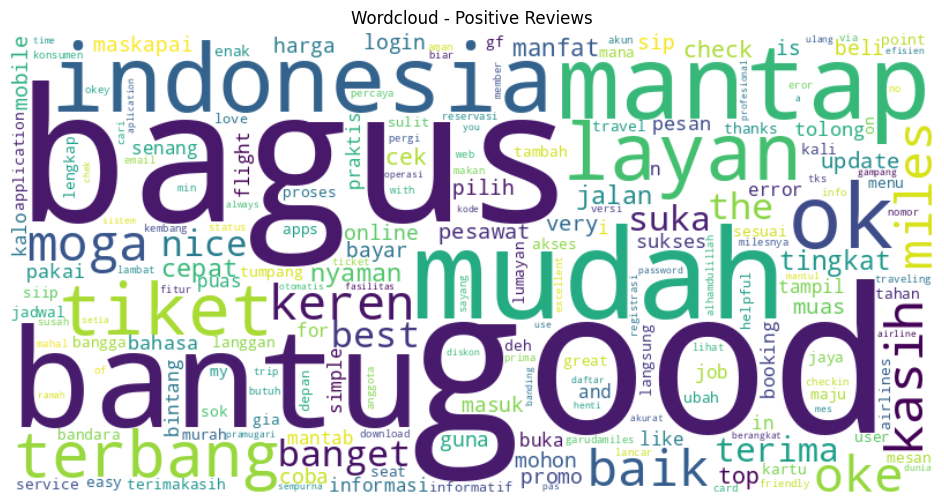

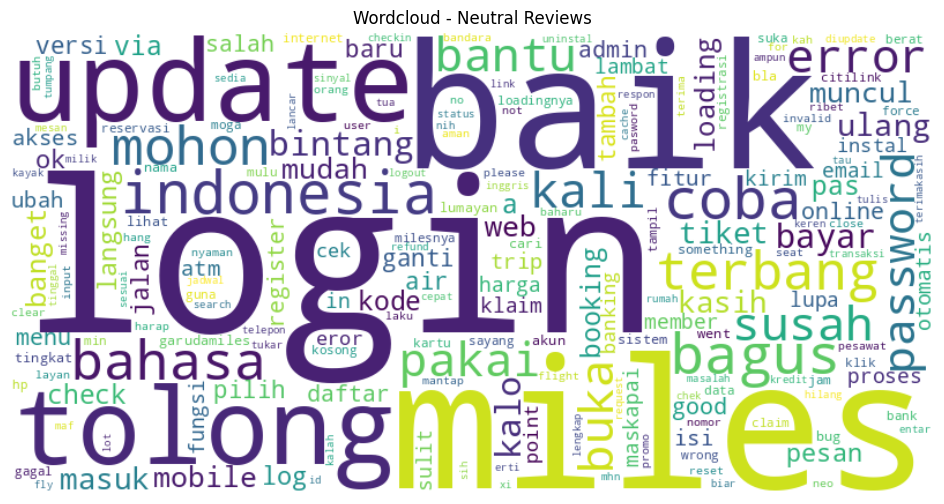

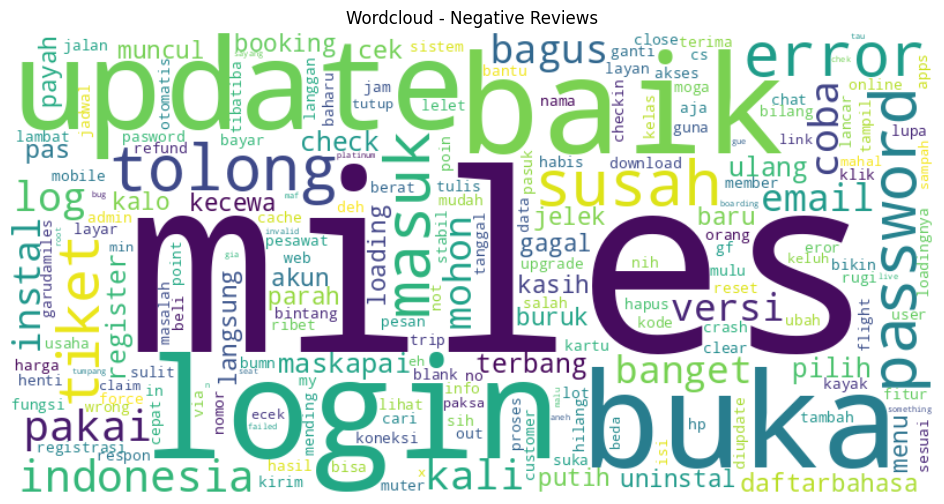

In [ ]:
# Wordcloud untuk setiap label sentimen

for label in ["positive","neutral","negative"]:
    subset_tokens = df_clean.loc[df_clean["sentiment"]==label, "tokens_clean"]
    counter = Counter(chain.from_iterable(subset_tokens))

    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis")\
         .generate_from_frequencies(counter)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud - {label.capitalize()} Reviews")
    plt.show()


/tmp/ipython-input-3794723683.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")


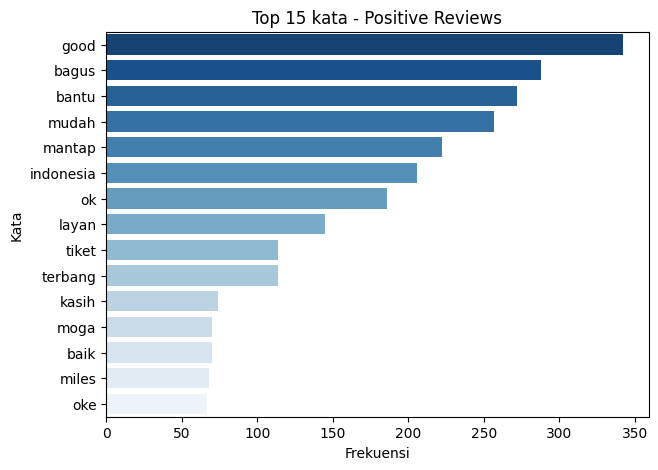

/tmp/ipython-input-3794723683.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")


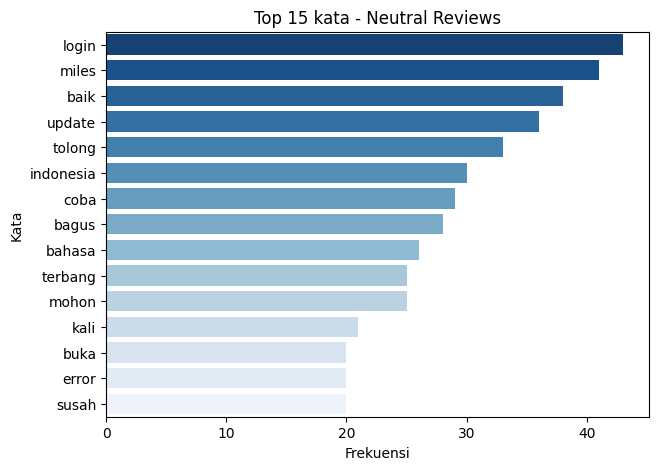

/tmp/ipython-input-3794723683.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")


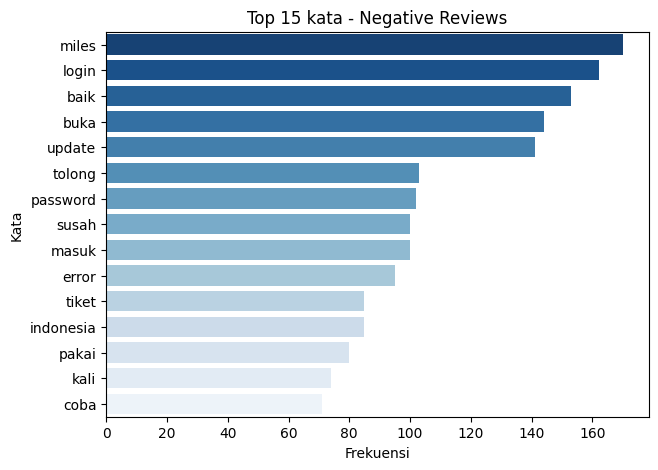

In [ ]:
# STEP 12c: Top kata per label sentimen
top_n = 15

for label in ["positive","neutral","negative"]:
    subset_tokens = df_clean.loc[df_clean["sentiment"]==label, "tokens_clean"]
    counter = Counter(chain.from_iterable(subset_tokens))
    top_words = pd.DataFrame(counter.most_common(top_n), columns=["word","count"])

    plt.figure(figsize=(7,5))
    sns.barplot(y="word", x="count", data=top_words, palette="Blues_r")
    plt.title(f"Top {top_n} kata - {label.capitalize()} Reviews")
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")
    plt.show()


In [ ]:
# STEP 13: Bigram & Trigram per sentimen
from collections import Counter

def get_ngrams(tokens, n=2):
    return list(zip(*[tokens[i:] for i in range(n)]))

for label in ["positive","neutral","negative"]:
    subset_tokens = df_clean.loc[df_clean["sentiment"]==label, "tokens_clean"]

    # Bigram
    bigram_counter = Counter()
    for toks in subset_tokens:
        bigram_counter.update(get_ngrams(toks, n=2))

    # Trigram
    trigram_counter = Counter()
    for toks in subset_tokens:
        trigram_counter.update(get_ngrams(toks, n=3))

    print(f"\n=== {label.upper()} REVIEWS ===")
    print("Top 10 bigram:")
    for bg, cnt in bigram_counter.most_common(10):
        print(f"{' '.join(bg):20s} {cnt}")

    print("\nTop 10 trigram:")
    for tg, cnt in trigram_counter.most_common(10):
        print(f"{' '.join(tg):25s} {cnt}")



=== POSITIVE REVIEWS ===
Top 10 bigram:
terima kasih         53
the best             42
beli tiket           24
is the               19
very good            18
bagus bantu          18
good job             18
tingkat layan        16
bahasa indonesia     16
mudah cepat          15

Top 10 trigram:
is the best               19
terima kasih indonesia    13
bantu beli tiket          5
indonesia is the          5
bagus bagus bagus         5
mudah beli tiket          4
maskapai bangga indonesia 4
mudah mesan tiket         4
pilih bahasa indonesia    4
bantu terima kasih        4

=== NEUTRAL REVIEWS ===
Top 10 bigram:
bahasa indonesia     17
tolong baik          16
mohon baik           11
something went       6
a a                  5
went wrong           5
login web            5
versi baru           5
pakai bahasa         4
a neo                4

Top 10 trigram:
something went wrong      5
pakai bahasa indonesia    3
a neo a                   3
please try again          2
a a neo           

#Eksplorasi per versi

Rata-rata score per major version:
major_version
1      4.268908
nan    4.057692
4      3.702381
6      3.628205
2      3.600000
3      3.354839
5      3.060314
Name: score, dtype: float64


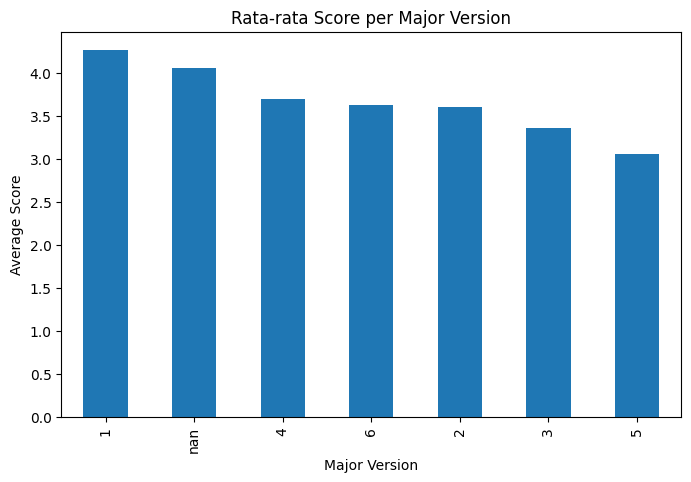

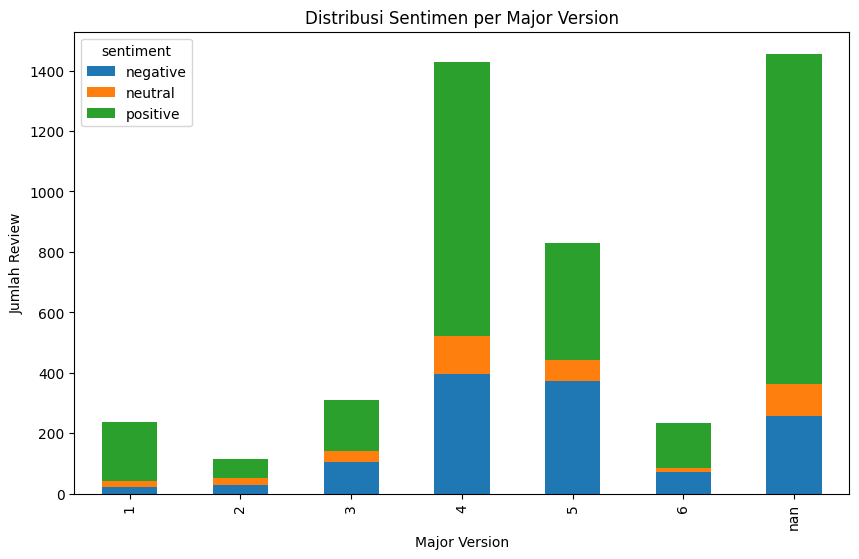

In [ ]:
# Rata-rata score & distribusi sentimen per major version

# buat kolom major version (ambil angka sebelum titik pertama)
df_clean["major_version"] = df_clean["reviewCreatedVersion"].astype(str).str.split(".").str[0]

# rata-rata score per major version
avg_score_major = df_clean.groupby("major_version")["score"].mean().sort_values(ascending=False)

print("Rata-rata score per major version:")
print(avg_score_major)

# Visualisasi rata-rata score
import matplotlib.pyplot as plt
avg_score_major.plot(kind="bar", figsize=(8,5))
plt.title("Rata-rata Score per Major Version")
plt.xlabel("Major Version")
plt.ylabel("Average Score")
plt.show()

# distribusi sentimen per major version
sent_by_major = df_clean.groupby(["major_version","sentiment"]).size().unstack(fill_value=0)

sent_by_major.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Distribusi Sentimen per Major Version")
plt.xlabel("Major Version")
plt.ylabel("Jumlah Review")
plt.show()


Kolom dengan tanggal: ['at']


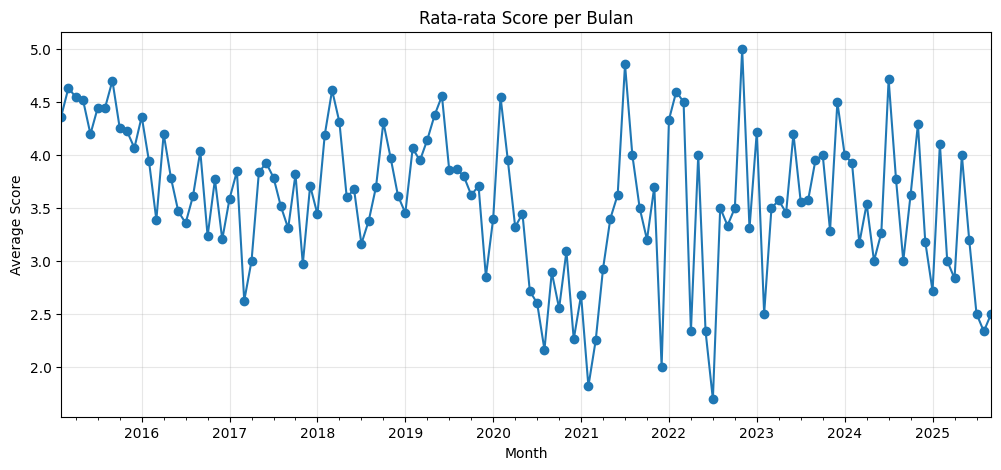

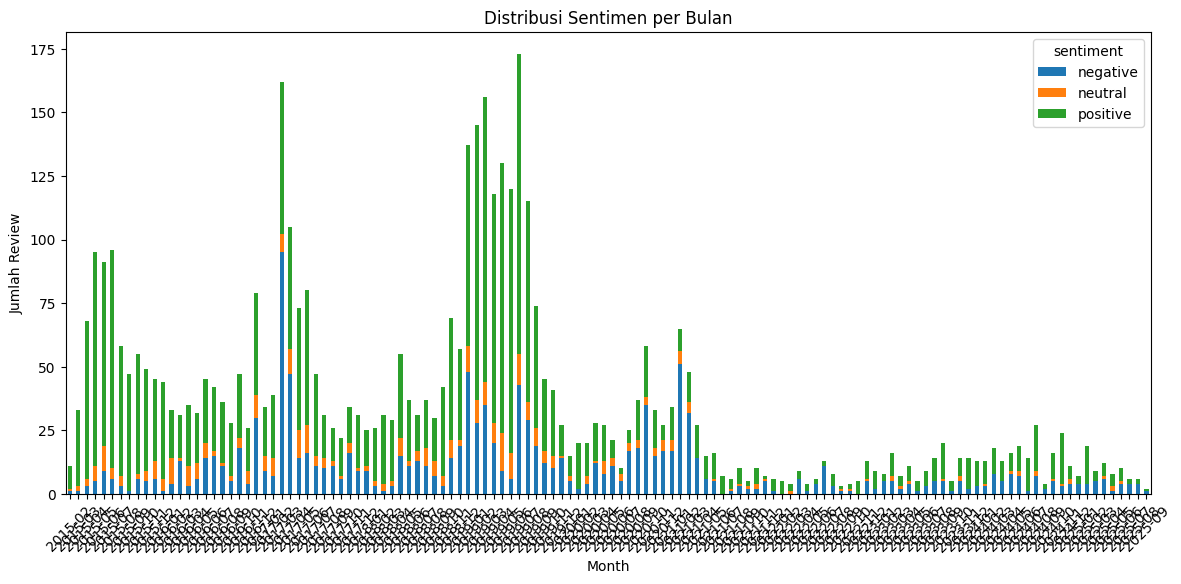

In [ ]:
# Tren waktu (per bulan)

DATE_COL = "at"

# konversi ke datetime
df_clean[DATE_COL] = pd.to_datetime(df_clean[DATE_COL], errors="coerce")

# group by bulan
df_clean["month"] = df_clean[DATE_COL].dt.to_period("M")

# rata-rata score per bulan
avg_score_by_month = df_clean.groupby("month")["score"].mean()

# 4) plot rata-rata score per bulan
plt.figure(figsize=(12,5))
avg_score_by_month.plot(marker="o")
plt.title("Rata-rata Score per Bulan")
plt.xlabel("Month")
plt.ylabel("Average Score")
plt.grid(alpha=0.3)
plt.show()

# 5) distribusi sentimen per bulan
sent_by_month = df_clean.groupby(["month","sentiment"]).size().unstack(fill_value=0)

sent_by_month.plot(kind="bar", stacked=True, figsize=(14,6))
plt.title("Distribusi Sentimen per Bulan")
plt.xlabel("Month")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=45)
plt.show()


Statistik thumbsUpCount:
count    4610.000000
mean        1.163991
std         4.730168
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        83.000000
Name: thumbsUpCount, dtype: float64


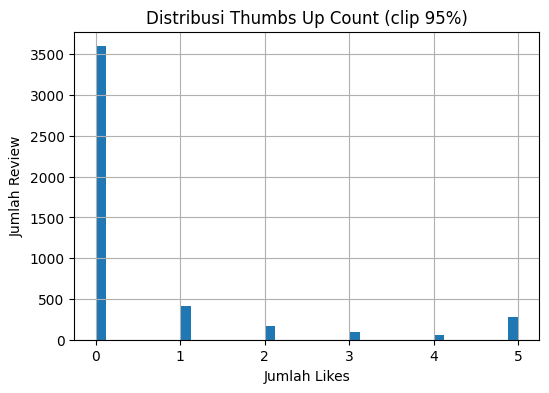


Rata-rata likes per sentimen:
sentiment
negative    2.510383
neutral     1.228426
positive    0.586707
Name: thumbsUpCount, dtype: float64


/tmp/ipython-input-3425883362.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_likes_sent.index, y=avg_likes_sent.values, palette="Set2")


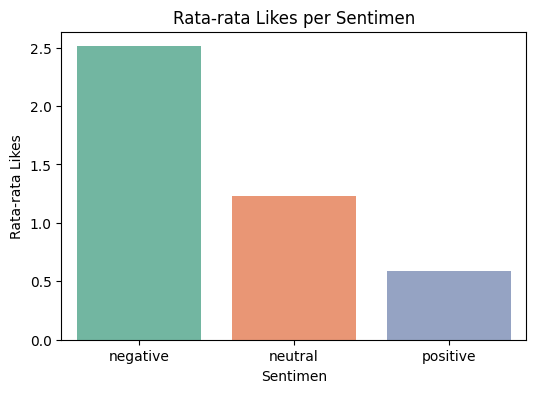


Korelasi Score vs Likes:
                 score  thumbsUpCount
score          1.00000       -0.17497
thumbsUpCount -0.17497        1.00000


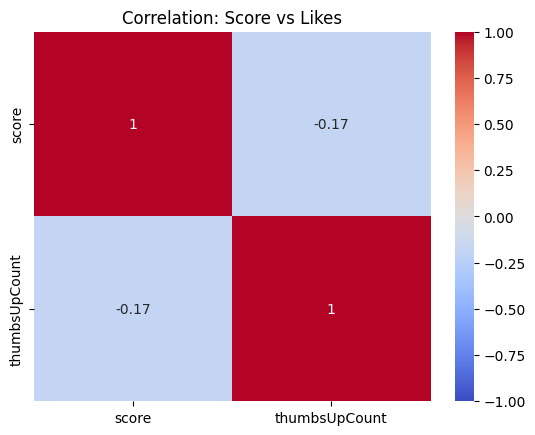

In [ ]:
# Analisis ThumbsUpCount

# cek distribusi thumbsUpCount
print("Statistik thumbsUpCount:")
print(df_clean["thumbsUpCount"].describe())

plt.figure(figsize=(6,4))
df_clean["thumbsUpCount"].clip(upper=df_clean["thumbsUpCount"].quantile(0.95)).hist(bins=40)
plt.title("Distribusi Thumbs Up Count (clip 95%)")
plt.xlabel("Jumlah Likes")
plt.ylabel("Jumlah Review")
plt.show()

#rata-rata likes per sentimen
avg_likes_sent = df_clean.groupby("sentiment")["thumbsUpCount"].mean()
print("\nRata-rata likes per sentimen:")
print(avg_likes_sent)

plt.figure(figsize=(6,4))
sns.barplot(x=avg_likes_sent.index, y=avg_likes_sent.values, palette="Set2")
plt.title("Rata-rata Likes per Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Rata-rata Likes")
plt.show()

# korelasi numerik (score vs likes)
corr = df_clean[["score","thumbsUpCount"]].corr()
print("\nKorelasi Score vs Likes:")
print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation: Score vs Likes")
plt.show()


In [ ]:
# Review dengan Likes terbanyak

top_reviews = (
    df_clean.sort_values(by="thumbsUpCount", ascending=False)
    [["score","sentiment","thumbsUpCount",TEXT_COL,"text_clean"]]
    .head(10)
)

pd.set_option("display.max_colwidth", 200)

print("=== Top 10 Review dengan Likes terbanyak ===")
display(top_reviews)


=== Top 10 Review dengan Likes terbanyak ===


,score,sentiment,thumbsUpCount,content_regex_norm,text_clean
3301,5,positive,83,tamu travel agent rekomendasi jasa terbang bangga komentarkomentar kualitas layan acung jempol coba sarana online booking mudahmudahan jalan,travel rekomendasi jasa terbang bangga kualitas layan jempol coba online booking mudahmudahan jalan
3824,1,negative,74,dukung bayar booking tiket via atm pakai kartu kredit internet banking payah,dukung bayar booking tiket via atm pakai kartu kredit internet banking payah
2444,5,positive,63,terkadang info mileage langsung update habis flight log of log update mileage mohon baik bantu member miles,terkadang info mileage langsung update habis flight log of log update mileage mohon baik bantu member miles
1149,4,positive,61,lumayan bantu layan kurang layan lounge sedia makan lengkap makan ringan minum layan kabin pesawat sedia minum kopi teh jus roti kacang air mineral mohon layan kembali puas langgan terimakasih,lumayan bantu layan kurang layan lounge sedia makan lengkap makan ringan minum layan pesawat sedia minum kopi air mohon layan kembali puas langgan terimakasih
599,2,negative,57,login email password klik forgot password masuk email buka booking tiket pesawat,login email password klik forgot password masuk email buka booking tiket pesawat
1846,2,negative,49,mohon baik sistem menu klaim milesnya pungsi error klaim miles berangkat timika jakarta jakarta balikpapan info check bandara masuk otomatis eh masuk input number id check in beda bandara bendar j...,mohon baik sistem menu klaim milesnya error klaim miles berangkat timika jakarta jakarta info check bandara masuk otomatis eh masuk input number id check in beda bandara jelas
699,1,negative,49,aaplikasi baru error nutup lihat miles paksa turunin bintang protes tanggap hapus cache instal ulang pengaruh masalah smartphone,baru error nutup lihat miles paksa turunin bintang protes tanggap hapus cache instal ulang pengaruh masalah smartphone
653,2,negative,48,dear developer mobile indonesia baik buka menu miles force closed hapus chace update instal ulang forced close ponsel beda,dear developer mobile indonesia baik buka menu miles force closed hapus chace update instal ulang forced close beda
1856,5,positive,48,malaysia bayar konfirmasi internet banking mohon jelas mu booking tiket,malaysia bayar konfirmasi internet banking mohon jelas mu booking tiket
3264,4,positive,48,dear doni rahmad putra bicara kasih masuk orangorang kait tanggap masuk langgan puas guru baik masuk,dear bicara kasih masuk orangorang kait tanggap masuk langgan puas baik masuk


In [ ]:
# STEP 14: Ringkasan temuan EDA

print("=== SUMMARY INSIGHT EDA FLYGARUDA REVIEWS ===\n")

print("1) Data Overview")
print(f"- Jumlah total review awal   : {len(df)}")
print(f"- Setelah cleaning (NaN dibuang, duplikat dibiarkan): {len(df_clean)}")
print(f"- Missing value              : 0 (sudah dibersihkan)")
print(f"- Duplikat                   : tetap dipertahankan (≈39%)\n")

print("2) Text Length")
print(f"- Panjang rata-rata review   : {df_clean['_token_len_clean'].mean():.2f} kata")
print(f"- Median                     : {df_clean['_token_len_clean'].median()} kata")
print(f"- Maksimal                   : {df_clean['_token_len_clean'].max()} kata\n")

print("3) Vocabulary")
print(f"- Kosakata awal              : 3,797 kata unik")
print(f"- Kosakata setelah cleaning  : 1,336 kata unik")
print("- Rare words (hapax) dihapus → hemat 64.8% vocab, hilang hanya 11.5% token\n")

print("4) Top Words (setelah cleaning)")
for w,c in clean_counter.most_common(10):
    print(f"  {w:12s} {c}")
print()

print("5) Sentiment Distribution")
print(df_clean['sentiment'].value_counts())
print()

print("6) Sentiment-specific signals")
print("- Positive reviews dominan kata pujian: bagus, good, mantap, mudah")
print("- Negative reviews dominan kata keluhan: login, miles, update, komplain")
print("- Neutral reviews lebih campuran, biasanya deskriptif\n")

print("7) Bigram/Trigram Patterns (contoh)")
# Ambil contoh top 3 dari masing-masing
for label in ["positive","negative"]:
    subset_tokens = df_clean.loc[df_clean["sentiment"]==label, "tokens_clean"]
    bigram_counter = Counter()
    for toks in subset_tokens:
        bigram_counter.update(zip(toks, toks[1:]))
    print(f"Top bigram {label}:")
    for bg, cnt in bigram_counter.most_common(3):
        print(" ", " ".join(bg), "-", cnt)
    print()


=== SUMMARY INSIGHT EDA FLYGARUDA REVIEWS ===

1) Data Overview
- Jumlah total review awal   : 4851
- Setelah cleaning (NaN dibuang, duplikat dibiarkan): 4610
- Missing value              : 0 (sudah dibersihkan)
- Duplikat                   : tetap dipertahankan (≈39%)

2) Text Length
- Panjang rata-rata review   : 4.09 kata
- Median                     : 2.0 kata
- Maksimal                   : 49 kata

3) Vocabulary
- Kosakata awal              : 3,797 kata unik
- Kosakata setelah cleaning  : 1,336 kata unik
- Rare words (hapax) dihapus → hemat 64.8% vocab, hilang hanya 11.5% token

4) Top Words (setelah cleaning)
  bagus        382
  good         353
  indonesia    321
  bantu        319
  mudah        295
  miles        279
  baik         261
  login        236
  mantap       228
  update       215

5) Sentiment Distribution
sentiment
positive    2964
negative    1252
neutral      394
Name: count, dtype: int64

6) Sentiment-specific signals
- Positive reviews dominan kata pujian: ba

In [ ]:
# Export dataset clean + tambahan 3 kolom

export_cols = [

    "content",
    "content_stemmed_no_common_2",
    "content_regex",
    "content_regex_norm",
    "text_clean",              # review bersih (rare words removed)
    "_tokens",                 # token awal sebelum rare words removal
    "tokens_clean",            # token setelah rare words removal
    "score",                   # rating bintang
    "sentiment",               # label sentimen
    "reviewCreatedVersion",    # versi aplikasi
    "major_version",           # versi mayor
    "at",                      # tanggal review
    "thumbsUpCount"         # jumlah likes

]


export_cols = [c for c in export_cols if c in df_clean.columns]

# Export ke CSV
OUTPUT_PATH = "flygaruda_reviews_clean_label.csv"
df_clean[export_cols].to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

print(f"Dataset berhasil diexport ke: {OUTPUT_PATH}")
print("Kolom yang diexport:", export_cols)


Dataset berhasil diexport ke: flygaruda_reviews_clean_label.csv
Kolom yang diexport: ['content', 'content_stemmed_no_common_2', 'content_regex', 'content_regex_norm', 'text_clean', '_tokens', 'tokens_clean', 'score', 'sentiment', 'reviewCreatedVersion', 'major_version', 'at', 'thumbsUpCount']


In [ ]:
df_cek = pd.read_csv("flygaruda_reviews_clean_label.csv")
df_cek.head()

,content,content_stemmed_no_common_2,content_regex,content_regex_norm,text_clean,_tokens,tokens_clean,score,sentiment,reviewCreatedVersion,major_version,at,thumbsUpCount
0,"harus belajar lagi bagaimana cara kau menghadapi kritik, btw makannmu tidak enak.! sorry say no saya tdk. lagi pakai ga lagi untuk bbrp waktu",ajar kau hadap kritik btw makannmu enak sorry sayang no tdk pakai,ajar kau hadap kritik btw makannmu enak sorry sayang no tdk pakai,ajar kau hadap kritik btw makannmu enak sorry sayang no tdk pakai,ajar kau kritik enak sorry sayang no pakai,"['ajar', 'kau', 'hadap', 'kritik', 'btw', 'makannmu', 'enak', 'sorry', 'sayang', 'no', 'tdk', 'pakai']","['ajar', 'kau', 'kritik', 'enak', 'sorry', 'sayang', 'no', 'pakai']",4,positive,6.16.0,6.0,2025-09-06 00:58:19,0
1,"maskapai maling, menipu customer dengan informasi palsu, info pada aplikasi tidak ada yang akan expired berapa bulan kedepan, nyatanya miles tiba-tiba sudah terpotong dari beberapa bulan sebelumny...",maskapai maling tipu customer informasi palsu info expired depan miles tibatiba potong komplain ber bulanbulan response jual panjang laku miles scam komplot maling jebak customer hatihati busuk,maskapai maling tipu customer informasi palsu info expired depan miles tibatiba potong komplain ber bulanbulan response jual panjang laku miles scam komplot maling jebak customer hatihati busuk,maskapai maling tipu customer informasi palsu info expired depan miles tibatiba potong komplain ber bulanbulan response jual panjang laku miles scam komplot maling jebak customer hatihati busuk,maskapai maling tipu customer informasi info expired depan miles tibatiba potong komplain ber jual panjang laku miles maling jebak customer busuk,"['maskapai', 'maling', 'tipu', 'customer', 'informasi', 'palsu', 'info', 'expired', 'depan', 'miles', 'tibatiba', 'potong', 'komplain', 'ber', 'bulanbulan', 'response', 'jual', 'panjang', 'laku', ...","['maskapai', 'maling', 'tipu', 'customer', 'informasi', 'info', 'expired', 'depan', 'miles', 'tibatiba', 'potong', 'komplain', 'ber', 'jual', 'panjang', 'laku', 'miles', 'maling', 'jebak', 'custom...",1,negative,NaN,NaN,2025-09-03 09:23:02,1
2,dulu dpt platinum bs 5-6 tahun g pernah turun... dgn kebijakan skrng malah megap2 bertahan d bronze/silver. kyknya ga usah pake poin2an gff deh. ga ada faedah jg walau sering naik garuda. sama aja...,platinum 56 turun bijak megap2 tahan bronzesilver kayak pakai poin2an gff deh faedah mamfaat guna jg kantor sih nyuruh faedah poin gff blue wkwkwkw anjir platinum upgrade blue,platinum turun bijak megap tahan bronzesilver kayak pakai poin an gff deh faedah mamfaat guna jg kantor sih nyuruh faedah poin gff blue wkwkwkw anjir platinum upgrade blue,platinum turun bijak megap tahan bronzesilver kayak pakai poin an gf deh faedah mamfat guna jg kantor sih nyuruh faedah poin gf blue wkwkwkw anjir platinum upgrade blue,platinum turun bijak tahan kayak pakai poin an gf deh faedah guna jg kantor sih faedah poin gf blue anjir platinum upgrade blue,"['platinum', 'turun', 'bijak', 'megap', 'tahan', 'bronzesilver', 'kayak', 'pakai', 'poin', 'an', 'gf', 'deh', 'faedah', 'mamfat', 'guna', 'jg', 'kantor', 'sih', 'nyuruh', 'faedah', 'poin', 'gf', '...","['platinum', 'turun', 'bijak', 'tahan', 'kayak', 'pakai', 'poin', 'an', 'gf', 'deh', 'faedah', 'guna', 'jg', 'kantor', 'sih', 'faedah', 'poin', 'gf', 'blue', 'anjir', 'platinum', 'upgrade', 'blue']",2,negative,6.17.0,6.0,2025-08-25 16:38:50,2
3,sy delay 20 jam dgn penerbangan conecting seharusnya sampai hari ini namun sampai hari berikutnya pd sore hari .. dan gatuda hy memberikn penginpn hotel dan transportasi bandara pp dari hotel.. se...,delay 20 jam terbang conecting sore gatuda hai memberikn penginpn hotel transportasi bandara pp hotel rugi sipertimbgkn kompensasi sky team mhn memikirkn kecewa tks,delay jam terbang conecting sore gatuda hai memberikn penginpn hotel transportasi bandara pp hotel rugi sipertimbgkn kompensasi sky team mhn memikirkn kecewa tks,delay jam terbang conecti

In [ ]:
df_cek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4610 entries, 0 to 4609
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   content                      4610 non-null   object 
 1   content_stemmed_no_common_2  4610 non-null   object 
 2   content_regex                4610 non-null   object 
 3   content_regex_norm           4610 non-null   object 
 4   text_clean                   4610 non-null   object 
 5   _tokens                      4610 non-null   object 
 6   tokens_clean                 4610 non-null   object 
 7   score                        4610 non-null   int64  
 8   sentiment                    4610 non-null   object 
 9   reviewCreatedVersion         3154 non-null   object 
 10  major_version                3154 non-null   float64
 11  at                           4610 non-null   object 
 12  thumbsUpCount                4610 non-null   int64  
dtypes: float64(1), int